In [1]:
import datetime
import numpy as np
import pandas as pd
from collections import Counter
import csv
import heapq
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchkeras import summary, kerasmodel
import warnings

warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 一些超参数设置
topK = 10
num_factors = 8
num_negatives = 4
batch_size = 64
lr = 0.001

In [2]:
# Global variables that are shared across processes
_model = None
_testRatings = None
_testNegatives = None
_K = None

# HitRation
def getHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            return 1
    return 0

# NDCG
def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return np.log(2) / np.log(i+2)
    return 0

def eval_one_rating(idx):   # 一次评分预测
    rating = _testRatings[idx]
    items = _testNegatives[idx]
    u = rating[0]
    gtItem = rating[1]
    items.append(gtItem)

    # Get prediction scores
    map_item_score = {}
    users = np.full(len(items), u, dtype='int32')

    test_data = torch.tensor(np.vstack([users, np.array(items)]).T).to(device)
    predictions = _model(test_data)
    for i in range(len(items)):
        item = items[i]
        map_item_score[item] = predictions[i].data.cpu().numpy()[0]
    items.pop()

    # Evaluate top rank list
    ranklist = heapq.nlargest(_K, map_item_score, key=lambda k: map_item_score[k])  # heapq是堆排序算法， 取前K个
    hr = getHitRatio(ranklist, gtItem)
    ndcg = getNDCG(ranklist, gtItem)
    return hr, ndcg

def evaluate_model(model, testRatings, testNegatives, K):
    """
    Evaluate the performance (Hit_Ratio, NDCG) of top-K recommendation
    Return: score of each test rating.
    """
    global _model
    global _testRatings
    global _testNegatives
    global _K

    _model = model
    _testNegatives = testNegatives
    _testRatings = testRatings
    _K = K

    hits, ndcgs = [], []
    for idx in range(len(_testRatings)):
        (hr, ndcg) = eval_one_rating(idx)
        hits.append(hr)
        ndcgs.append(ndcg)
    return hits, ndcgs

In [3]:
# 版本一：不正则化
# def loss_func(output, target, model, reg_lambda=0):
#     loss = nn.BCELoss()(output, target)
#     reg_loss = 0
#     for name, param in model.named_parameters():
#         reg_loss += 0.5 * reg_lambda * torch.sum(param ** 2)
#     total_loss = loss + reg_loss
#     return total_loss
# 版本二：仅对嵌入层权重正则化
# def loss_func(output, target, model, reg_lambda=0.01):
#     loss = nn.BCELoss()(output, target)
#     reg_loss = 0
#     for name, param in model.named_parameters():
#         # 仅对嵌入层权重正则化
#         if 'linear.weight' not in name and 'linear.bias' not in name:
#             reg_loss += 0.5 * reg_lambda * torch.sum(param ** 2)
#     total_loss = loss + reg_loss
#     return total_loss
# # 版本三：仅对线性层权重正则化
def loss_func(output, target, model, reg_lambda=0.1):
    loss = nn.BCELoss()(output, target)
    reg_loss = 0
    for name, param in model.named_parameters():
        # 仅对线性层权重正则化
        if 'linear.weight' in name:
            reg_loss += 0.5 * reg_lambda * torch.sum(param ** 2)
    total_loss = loss + reg_loss
    return total_loss

In [4]:
# 数据采样
def get_train_instances(train, num_negatives):
    np.random.seed(123)
    user_input, item_input, labels = [], [], []
    num_items = train.shape[1]
    for (u, i) in train.keys():  # train.keys()是打分的用户和商品
        user_input.append(u)
        item_input.append(i)
        labels.append(1)
        for t in range(num_negatives):
            j = np.random.randint(num_items)
            while (u, j) in train:
                j = np.random.randint(num_items)
            user_input.append(u)
            item_input.append(j)
            labels.append(0)
    return user_input, item_input, labels
# GMF实现类
class GMF(nn.Module):
    def __init__(self, num_users, num_items, latent_dim, regs=[0, 0]):
        super(GMF, self).__init__()
        self.MF_Embedding_User = nn.Embedding(num_embeddings=num_users, embedding_dim=latent_dim)
        self.MF_Embedding_Item = nn.Embedding(num_embeddings=num_items, embedding_dim=latent_dim)
        self.linear = nn.Linear(latent_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, inputs):
        inputs = inputs.long()
        MF_Embedding_User = self.MF_Embedding_User(inputs[:, 0])  # 这里踩了个坑， 千万不要写成[0]， 我们这里是第一列
        MF_Embedding_Item = self.MF_Embedding_Item(inputs[:, 1])
        predict_vec = torch.mul(MF_Embedding_User, MF_Embedding_Item)
        linear = self.linear(predict_vec)
        output = self.sigmoid(linear)
        return output
# DataLoader
train = np.load('ProcessedData/train.npy', allow_pickle=True).tolist()
testRatings = np.load('ProcessedData/testRatings.npy').tolist()
testNegatives = np.load('ProcessedData/testNegatives.npy').tolist()
train = train[:500]
testRatings = testRatings[:500]
testNegatives = testNegatives[:500]
num_users, num_items = train.shape
user_input, item_input, labels = get_train_instances(train, num_negatives)
train_x = np.vstack([user_input, item_input]).T
labels = np.array(labels)
train_dataset = TensorDataset(torch.tensor(train_x), torch.tensor(labels).float())
dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# 模型实例化
model = GMF(num_users, num_items, num_factors)
model.to(device)
# 参数设置
epochs = 71
np.random.seed(123)
# loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
# 存储结果
test_csv_path = './result/GMF_onlyLinear_nobais01.csv'
test_csv_file = open(test_csv_path, 'w', newline='')
test_csv_writer = csv.writer(test_csv_file)
test_csv_writer.writerow(['Epoch', 'LOSS', 'NDCG', 'HR'])
# 模型训练与评估
for epoch in range(epochs):
    model.train()
    loss_sum = 0.0
    for step, (features, labels) in enumerate(dl_train, 1):
        features, labels = features.cuda(), labels.cuda()
        optimizer.zero_grad()
        predictions = model(features)
        predictions = predictions.squeeze(1)
        loss = loss_func(predictions, labels, model)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
    model.eval()
    (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK)
    hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
    test_csv_writer.writerow([epoch, loss_sum/step, ndcg, hr])
    info = (epoch, loss_sum/step, hr, ndcg)
    print(("\nEPOCH = %d, loss = %.3f, hr = %.3f, ndcg = %.3f") %info)
test_csv_file.close()


EPOCH = 0, loss = 0.516, hr = 0.096, ndcg = 0.044

EPOCH = 1, loss = 0.500, hr = 0.112, ndcg = 0.052

EPOCH = 2, loss = 0.500, hr = 0.114, ndcg = 0.051

EPOCH = 3, loss = 0.495, hr = 0.156, ndcg = 0.081

EPOCH = 4, loss = 0.469, hr = 0.242, ndcg = 0.132

EPOCH = 5, loss = 0.422, hr = 0.342, ndcg = 0.193

EPOCH = 6, loss = 0.385, hr = 0.388, ndcg = 0.222

EPOCH = 7, loss = 0.365, hr = 0.414, ndcg = 0.243

EPOCH = 8, loss = 0.353, hr = 0.424, ndcg = 0.245

EPOCH = 9, loss = 0.346, hr = 0.434, ndcg = 0.248

EPOCH = 10, loss = 0.340, hr = 0.436, ndcg = 0.246

EPOCH = 11, loss = 0.335, hr = 0.452, ndcg = 0.253

EPOCH = 12, loss = 0.330, hr = 0.446, ndcg = 0.253

EPOCH = 13, loss = 0.325, hr = 0.448, ndcg = 0.253

EPOCH = 14, loss = 0.320, hr = 0.460, ndcg = 0.260

EPOCH = 15, loss = 0.315, hr = 0.472, ndcg = 0.264

EPOCH = 16, loss = 0.310, hr = 0.474, ndcg = 0.264

EPOCH = 17, loss = 0.305, hr = 0.484, ndcg = 0.271

EPOCH = 18, loss = 0.301, hr = 0.484, ndcg = 0.269

EPOCH = 19, loss = 0.

In [5]:
# list(model.named_parameters())

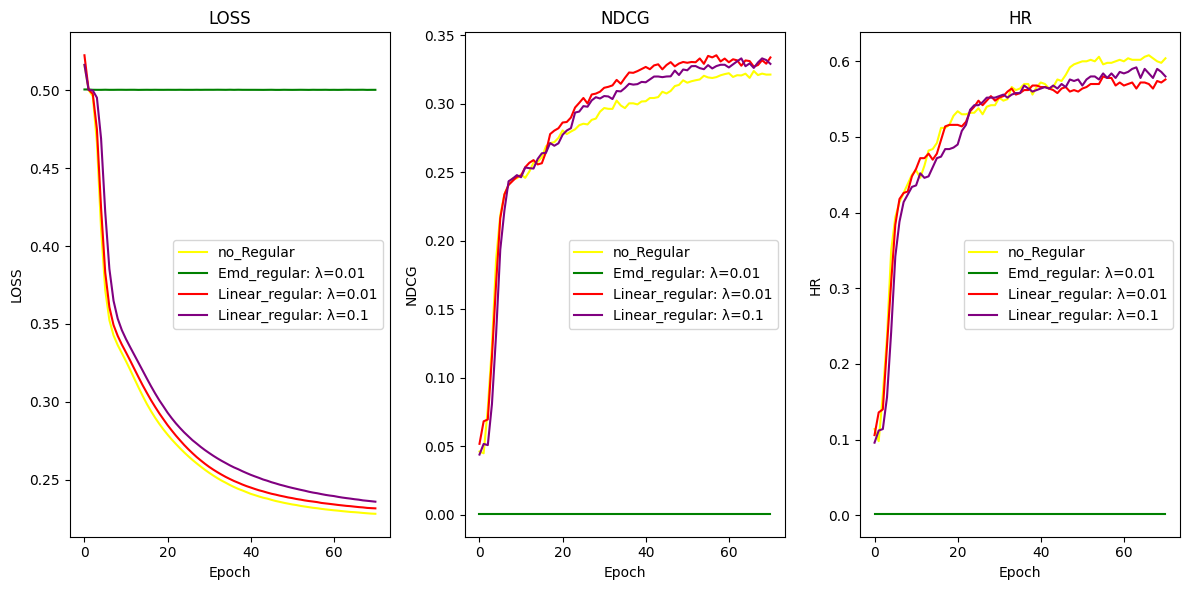

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取四个CSV文件
file_paths = ["./result/GMF_no.csv", "./result/GMF_onlyEmd.csv", "./result/GMF_onlyLinear_nobais001.csv", "./result/GMF_onlyLinear_nobais01.csv"]
label = ["no_Regular", "Emd_regular: λ=0.01", "Linear_regular: λ=0.01", "Linear_regular: λ=0.1"]
dfs = [pd.read_csv(file) for file in file_paths]

# 定义颜色列表，用于绘制不同文件的折线
colors = ['yellow', 'green', 'red', 'purple']

# 绘制三张折线图
plt.figure(figsize=(12, 6))

# 遍历三个属性列
for col in ["LOSS", "NDCG", "HR"]:
    plt.subplot(1, 3, ["LOSS", "NDCG", "HR"].index(col) + 1)
    plt.title(col)

    # 遍历四个文件
    for i, df in enumerate(dfs):
        # 将DataFrame转换为NumPy数组
        epoch_values = df["Epoch"].values
        col_values = df[col].values
        plt.plot(epoch_values, col_values, label=label[i], color=colors[i])

    plt.xlabel("Epoch")
    plt.ylabel(col)
    plt.legend()

plt.tight_layout()
plt.show()